# Imports and basic set up

In [1]:
#In the begining, ther is time
import time

In [2]:
#Quality of life
#Some things we do generate a lot of warnings, and it just becomes clutter.
import warnings
warnings.filterwarnings("ignore")
#I like it when my notebook helps me out
%config IPCompleter.greedy=True
#Sometiems you just need to print pretty
from pprint import pprint
#Lots of these operations take many minutes to complete. So it behooves us to pickle the outputs and just unpickle them each time we re-open the notebook
import pickle


Data is from: https://www.kaggle.com/datasets/toygarr/datasets-for-natural-language-processing

Dataset is from a collection of sentiment datasets, but we just want to play with the food one for now.

"ctweet, stweet, food" datasets are positive or negative analysis (sentiment) -> 0 negative -> 1 positive (ctweet has neutral 0, 1, 2)

we're assuming that any code we write to deal with this food data set will be extensible later by simply adding the rest of the data if we so choose. At the moment it's simply faster to work with a smaller subset of the data as we design the pipeline and it's displays.

## Utilities

In [3]:
import pandas as pd
import nltk
import numpy as np
from collections import Counter


## Visualization Tools

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


## Corpus and Vectoring tools

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


Target variable percentage. 

In [57]:
#1 = positive
#0 = Negative
df.Y.value_counts()

1    306223
0     56996
Name: Y, dtype: int64

In [6]:
56996/306223 * 100

18.61257972131421

# Word Clouds/bar charts
### divided by sentiment lables

Make giant strings for each set of words. Total, negative sentiment, and positive sentiment

In [7]:
start = time.time()

test = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Sentiment-Capstone/data/food/test.csv')
train = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Sentiment-Capstone/data/food/train.csv')
frames = [train, test]
df = pd.concat(frames)

stop = time.time()
print("this took " +str(stop-start) + " seconds to complete")

this took 2.396538734436035 seconds to complete


In [8]:
start = time.time()

df['tokenized'] = df.text.apply(word_tokenize)

stop = time.time()
print("this took " +str(stop-start) + " seconds to complete")

this took 116.34544563293457 seconds to complete


In [9]:
start = time.time()

stopwords = nltk.corpus.stopwords.words("english")
df['nostops'] = df.tokenized.apply(lambda  x: [item for item in x if item not in stopwords])

stop = time.time()
print("this took " +str(stop-start) + " seconds to complete")

this took 43.98896098136902 seconds to complete


In [10]:
start = time.time()

nostops_text_no_mods = " ".join(" ".join(listo) for listo in df.nostops)

stop = time.time()
print("this took " +str(stop-start) + " seconds to complete")

this took 0.6211395263671875 seconds to complete


In [11]:
nostops_text_pos = " ".join(" ".join(listo) for listo in df.nostops[df['Y'] == 1])

In [12]:
nostops_text_neg = " ".join(" ".join(listo) for listo in df.nostops[df['Y'] == 0])

In [13]:
def word_cloud_preprocessing(text):
    #I just love knowing how long my functions take to execute
    start = time.time()
    total_text_word_count = Counter(word_tokenize(text))
#     for stop in stopwords:
#         if stop in total_text_word_count.keys():
#             del total_text_word_count[stop]
    count_dict = dict(total_text_word_count, index=(len(total_text_word_count)))
    series_for_heads = pd.Series(count_dict)
    x = series_for_heads.sort_values(ascending=False).head(15).index
    y = series_for_heads.sort_values(ascending=False).head(15)
    stop = time.time()
    print(str(stop-start))
    #build the actual wordcloud boject
    total_wordcloud = WordCloud(max_font_size=50, max_words=25, background_color="black",
                               width=400,
                                height=400,
                                relative_scaling=1,
                                colormap='winter',
                                collocations=False,
                                stopwords=stopwords,
                                scale=2
                            
                               ).generate(text)
    stop = time.time()
    print(str(stop-start))
    return x, y, total_wordcloud

In [14]:
def word_cloud(x, y, wordcloud):
    # Display the generated image:
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #testing setting figsize on subfigure directly, rather than at this higher level
    #sns.set(rc = {'figure.figsize':(40,5)})
    
    axes[0].set_title('Top Word counts')
    sns.barplot(x, y, ax=axes[0], palette="winter")
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].axis("off")
    axes[1].set_title('Word Cloud')
    plt.show()

In [15]:
def bar_and_cloud_generator(text):
    bar_x, bar_y, cloud_object = word_cloud_preprocessing(text)
    word_cloud(bar_x, bar_y, cloud_object)

## All words

53.980210065841675
70.95707869529724


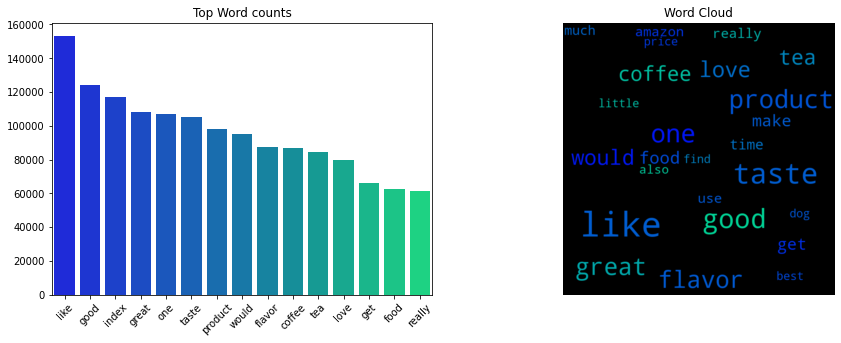

In [16]:
bar_and_cloud_generator(nostops_text_no_mods)

# Words from sentances labeled positive

All the way to product this is consistent to the total word count

45.19904136657715
59.60311579704285


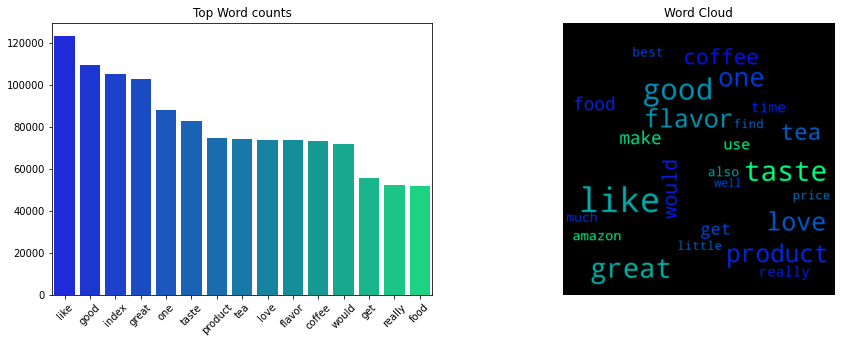

In [17]:
bar_and_cloud_generator(nostops_text_pos)

# Words from sentances labeled negative

9.203644037246704
12.18154525756836


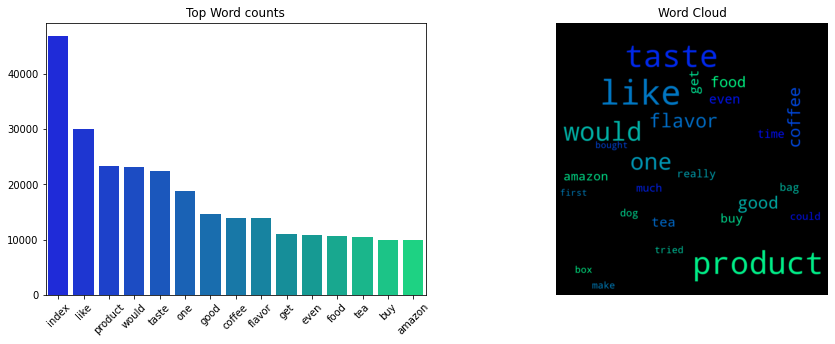

In [18]:
bar_and_cloud_generator(nostops_text_neg)

We can see there's considerable overlap between all three ways of organizing our corpus.

# Building Limited Vocabularies

In [19]:
neg_list = nostops_text_neg.split(' ')
neg_set = set(neg_list)

In [20]:
pos_list = nostops_text_pos.split(' ')
pos_set = set(pos_list)

In [21]:
print('neg list len = ' + str(len(neg_list)))
print('neg set len = ' + str(len(neg_set))) 

neg list len = 2334177
neg set len = 46886


In [22]:
print('pos list len = ' + str(len(pos_list)))
print('pos set len = ' + str(len(pos_set))) 

pos list len = 11470406
pos set len = 104877


## Extracting Negative Only words

In [23]:
neg_only_set = neg_set - pos_set
len(neg_only_set )

11892

## Extracting Positive Only Words

## Extracting word ratios

Using set logic to snag words that only appear in both positive and negative polarity documents

In [25]:
shared_set = neg_set.intersection(pos_set)
len(shared_set)

34994

In [26]:
ratio_dict = {}

In [27]:
ratio_df =  pd.DataFrame(shared_set)

In [28]:
ratio_df.transpose

<bound method DataFrame.transpose of                    0
0                   
1              adept
2              boyer
3                ike
4             rowing
...              ...
34989    conservancy
34990          cindy
34991      wallowing
34992  disintegrated
34993           part

[34994 rows x 1 columns]>

In [29]:
neg_count = {}

for word in neg_list:
    if word in shared_set:
        if word not in neg_count.keys():
            
            neg_count[word] = 0
            
        neg_count[word] += 1
        
neg_count_df = pd.DataFrame(neg_count, index=[0])
                            
neg_count_df = neg_count_df.transpose()

In [30]:
len(set(neg_list))

46886

In [31]:
neg_count_df

,0
love,5987
flower,126
teasi,1
purchase,3053
often,601
...,...
upton,1
shuttered,1
burrow,1
uncanny,1


In [32]:
pos_count = {}

In [33]:
for word in pos_list:
    if word in shared_set:
        if word not in pos_count.keys():
            pos_count[word] = 0
        pos_count[word] += 1

pos_count_df = pd.DataFrame(pos_count, index=[0])
pos_count_df = pos_count_df.transpose()
ratio_df = ratio_df.set_index(0)

In [34]:
pos_count_df = pd.DataFrame(pos_count, index=[0])
pos_count_df = pos_count_df.transpose()
ratio_df = ratio_df.set_index(0)

In [35]:
pos_count_df.head(2)

,0
put,16759
first,30020


In [36]:
pos_count_df[0].head(2)

put      16759
first    30020
Name: 0, dtype: int64

In [37]:
ratio_df

""
0
""
adept
boyer
ike
rowing
...
conservancy
cindy
wallowing


In [38]:
ratio_df['neg_count'] = neg_count_df[0]
ratio_df['pos_count'] = pos_count_df[0]

In [39]:
ratio_df['ratio'] = ratio_df[['neg_count','pos_count']].mean(axis=1)

In [40]:
ratio_df.sort_values(by='ratio', ascending=False).head(1000)

,neg_count,pos_count,ratio
0,,,
like,30069,123214,76641.5
good,14619,109471,62045.0
great,5792,102611,54201.5
one,18773,88085,53429.0
taste,22369,82632,52500.5
...,...,...,...
raspberry,425,2009,1217.0
lost,551,1878,1214.5
servings,333,2095,1214.0


In [41]:
ratio_df.ratio.sort_values(ascending=False).head(1000)

0
like         76641.5
good         62045.0
great        54201.5
one          53429.0
taste        52500.5
              ...   
raspberry     1217.0
lost          1214.5
servings      1214.0
stand         1213.0
paste         1212.5
Name: ratio, Length: 1000, dtype: float64

In [42]:
ratio_df.ratio[ratio_df['ratio'] == 1].count()

2959

(array([62., 11., 13.,  3.,  2.,  4.,  3.,  1.,  0.,  1.]),
 array([10064.5, 16722.2, 23379.9, 30037.6, 36695.3, 43353. , 50010.7,
        56668.4, 63326.1, 69983.8, 76641.5]),
 <BarContainer object of 10 artists>)

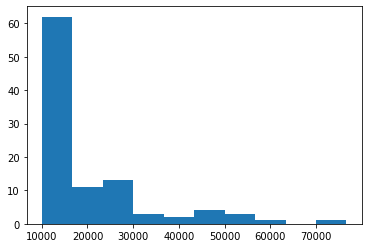

In [43]:
plt.hist(ratio_df.ratio.sort_values(ascending=False).head(100))

# Counting Total appearance of words

In [44]:
all_list = nostops_text_no_mods.split(' ')
all_set = set(all_list)

In [45]:
len(all_list)

13804583

In [46]:
all_count = {}
for word in all_list:
    if word not in all_count.keys():
        all_count[word] = 0
    all_count[word] += 1
all_count_df = pd.DataFrame(all_count, index=[0])    
all_count_df = all_count_df.transpose()

In [47]:
all_count_df.sort_values(ascending=False, by=0).head(20)

,0
like,153283
good,124090
great,108403
one,106858
taste,105001
product,97973
would,94926
flavor,87398
coffee,87153
tea,84339


### Neg only Count DF

In [48]:
#Building up the count for the neg only df so that we can order them to slice, so we can add them to the lexicon we're going to feed into the vocabulary of the tokenizer

neg_count = {}

for word in neg_list:
    if word in neg_only_set:
        if word not in neg_count.keys():
            
            neg_count[word] = 0
            
        neg_count[word] += 1
        
neg_count_df = pd.DataFrame(neg_count, index=[0])
                            
neg_only_count_df = neg_count_df.transpose()

len(neg_only_set)

11892

In [49]:
neg_only_count_df.sort_values(by=[0], ascending=False).head(100)

,0
bbd,30
refundable,23
canavanine,19
unreturnable,13
iarc,11
...,...
ribes,5
chastised,5
diamondpetrecall,5
algam,5


# Negative Sentiment Only Word count Analysis
Within 100 words these words are showing up in as few as 5 documents, so as an generalizable indicator they're pretty weak. I'm inclined to spend our dimensionality on some other list of words, or the LDA topics. Also worth noting bbd. iarc and diamondpetrecall. All store names, might be able to purge these by using a part of speach tagger and removing proper nouns? Might not be worth it if I'm not using pos or neg only lists, and just using high ratio words with LDA topics.

### Pos Only Count Df

In [53]:
#Building up the count for the neg only df so that we can order them to slice, so we can add them to the lexicon we're going to feed into the vocabulary of the tokenizer

pos_count = {}

for word in pos_list:
    if word in pos_only_set:
        if word not in pos_count.keys():
            
            pos_count[word] = 0
            
        pos_count[word] += 1
        
pos_count_df = pd.DataFrame(pos_count, index=[0])
                            
pos_only_count_df = pos_count_df.transpose()

len(pos_only_set)

69883

In [54]:
pos_only_count_df.sort_values(by=[0], ascending=False).head(100)

,0
excellant,143
hears,122
vernor,115
tri,109
pleaser,83
...,...
somersaults,35
stickier,35
baltimore,35
caveats,34


In [59]:
30 * 5


150

In [107]:
list(pos_only_count_df.sort_values(by=[0], ascending=False).head(100).index)

['excellant',
 'hears',
 'vernor',
 'tri',
 'pleaser',
 'flavonoids',
 'listmania',
 'yummm',
 'blanc',
 'teachers',
 'raven',
 'drizzling',
 'yummiest',
 'unwind',
 'supersaver',
 'mmmmmmm',
 'nando',
 'matchas',
 'saponin',
 'loin',
 'vege',
 'bisto',
 'willpower',
 'unfrosted',
 'muscovado',
 'hydrates',
 'lizano',
 'simplest',
 'convienent',
 'trepidation',
 'coolest',
 'awaken',
 'rv',
 'slump',
 'psoriasis',
 'medela',
 'limping',
 'outings',
 'satisfyingly',
 'flor',
 'bonnet',
 'rotel',
 'grad',
 'overdoing',
 'vacations',
 'tucson',
 'stroller',
 'glutten',
 'winona',
 'broiler',
 'pittsburgh',
 'smoothe',
 'stiffness',
 'fluctuates',
 'daytime',
 'radius',
 'lollies',
 'yummmmm',
 'uplifting',
 'golazo',
 'takeout',
 'reheats',
 'tahina',
 'clint',
 'powerhouse',
 'shinny',
 'retreat',
 'spiciest',
 'handbag',
 'pates',
 'teasan',
 'relieves',
 'pastrami',
 'mmmmmmmm',
 'pei',
 'versitile',
 'bzzagent',
 'yummo',
 'shar',
 'ski',
 'panera',
 'garvey',
 'tignor',
 'eleuthero',

# Positive Sentiment Only Word count Analysis
We can see that the most common positive word is nearly five times as common as the most common negative only word, which makes sense given that negative documents make up only 18% of our corpus. THe ratio is almost exact. Seperate from the generalizability pushing me away from sentiment unique words, it may behoove us to throw in some negative only given that our model have been biasing towards 100% positive regardless. Though some words here are obviously going to trend towards predictive, like ecellant. Hears is suprising, no idea bout vernor(brand maybe?) tri is also strange, pleaser is a strange iteration but makes sense that it would be in this list

# Function to slice the vectors appropriately

In [121]:
def slicer(pos_only, neg_only, high_ratio):
    
    #slice pos
    pos_slice = list(pos_only_count_df.sort_values(by=[0], ascending=False).head(pos_only).index)
    print(len(pos_slice))
    #slice neg
    neg_slice = list(neg_only_count_df.sort_values(by=[0], ascending=False).head(neg_only).index)
    print(len(neg_slice))
    #slice high_ratio
    ratio_slice = list(ratio_df.sort_values(ascending=False, by='ratio').head(high_ratio+1).index)[1:]
    print(len(ratio_slice))
    
    
    #Join slices into one big list
    sliced_lexicons = [pos_slice,neg_slice,ratio_slice]
    sliced_lexicon = []
    for lexicon in sliced_lexicons:
        for word in lexicon:
            sliced_lexicon.append(word)
        
    #Return list
    return pos_slice,neg_slice,ratio_slice, sliced_lexicon

## Visualizing the LDA

This graphic was made early on in the process. It continues to be useful, but eventually it became prudent to move the LDA process to the preprocessing noteboook so that the project could be conceptually silod more effectively. If your curious about the code that the below function referenced before it just loaded a file check out the preprocessing notebook

In [ ]:
#Tools for lDA visualization

#Normally I like to my imports at the top of a ntoebook, but these imports make the
#notebook spam an annoying warning that I can only fix by downgrading some stuff, which I am disinclined to do.
import pyLDAvis.gensim_models 
import pyLDAvis

In [ ]:
num_topics=10
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 0:
    LDAvis_prepared = pyLDAvis.gensim_models .prepare(lda, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

This is pretty neat, but honestly I don't care very much. These distributions don't really affect what I'm about to do. I was just curious to try this.

We might do something similar to the earlier word clouds and break this up by sentiment. SEe if the clusters are significantly different across sentiments, but again it's not deeply relevant to our long term goals, so we may not take the time